**Chapter 4 – Training Linear Models**

Before we used ML models without understanding how they work. Now we will try to look under the hood. We will look at two versions of Linear regression: regular closed-form equation $ \beta = \frac{X'Y}{X'X}$ and iterative optimization Gradient Descent (GD) approach which tweaks model parameters to minimize cost function. Even though eventually GD will converge to the parameters $\beta$ estimated by the first method, GD is the important concepts that will help us to study neural networks. 

Next we will look at the polynomial regression, which is more flexible than linear regression. It has more parameters and more prone to overfitting. Finally, we will look at regression models used in classification: Logistic Regression and Softmax Regression. 

In Chapter 1, we looked at simple regression: <br> <br>
$life\_satisfaction = \theta_0 + \theta_1 \times GDP\_percapita$ <br> <br>
This is a linear function of the input feature of one input feature. The model parameters are $\theta_0$ and $\theta_1$. In general regression has the following form: <br> <br>
$$ \hat{y} = \theta_0 + \theta_1 x_1 +  \theta_2 x_2 + ... +  \theta_n x_n$$
* $\hat{y}$ is the predicted value
* $n$ is the number of features
* $x_i$ is the $i^{th}$ feature
* $\theta_j$ is the $j^{th}$ model parameters. Number of parameters is $n+1$ because of the constant




We can write linear regression in the vector form:
$$ \hat{y} = h_{\theta} (x) = \theta^T \cdot x $$

* $\theta^T$ is the transpose of vector of parameters or feature weights $\theta$.
* $\theta^T \cdot x $ is the dot product of vector of parameters $\theta^T$ and vector of features $x$.
* $h_{\theta} (x)$ is the hypothesis function or prediction using parameters $\theta$

First we train linear regression on training data minimizing Mean Square Error (MSE). Usually we use Root Mean Square Error (RMSE) as a metric to compare OLS models, the same set of parameters minimize both MSE and RMSE. 
$$ MSE(X, h_\theta) = \frac{1}{m}\sum^m_{i=1} \big(\theta^T \cdot x^{(i)} - y^{(i)}\big)^2$$

Later we will refer to $h_\theta$ as just $h$, and $MSE(\theta)$ instead of $MSE(X,h_\theta)$

Normal regression find $\theta$ that minimizes MSE:
$$ \hat{\theta} = (\pmb{X}^T \cdot \pmb{X})^{-1} \cdot \pmb{X}^T \cdot \pmb{y}$$
*  $\hat{\theta}$ is the $\theta$ that minimizes MSE
*  $\pmb{\theta}$ is the vector of target values $y^{(1)}$ to $y^{(m)}$.

**Note**: the first releases of the book implied that the `LinearRegression` class was based on the Normal Equation. This was an error, my apologies: as explained above, it is based on the pseudoinverse, which ultimately relies on the SVD matrix decomposition of $\mathbf{X}$ (see chapter 8 for details about the SVD decomposition). Its time complexity is $O(n^2)$ and it works even when $m < n$ or when some features are linear combinations of other features (in these cases, $\mathbf{X}^T \mathbf{X}$ is not invertible so the Normal Equation fails), see [issue #184](https://github.com/ageron/handson-ml/issues/184) for more details. However, this does not change the rest of the description of the `LinearRegression` class, in particular, it is based on an analytical solution, it does not scale well with the number of features, it scales linearly with the number of instances, all the data must fit in memory, it does not require feature scaling and the order of the instances in the training set does not matter.

There is a mistake in the book: the LinearRegression class does not actually use the Normal Equation, it computes the pseudoinverse of X (specifically the Moore-Penrose pseudoinverse), and it multiplies it by y. It gives the same result as the normal equation, but it has two important advantages:

It is $O(n^2)$ instead of $O(n^2.4)$ to $O(n^3)$. So it's much faster than the Normal Equation when there are many features.
It behaves better when some of the eigenvalues of X are small (or equal to zero). In plain English, this is when some features are highly correlated (or perfectly correlated, that is when one feature is a linear combination of the others). It also behaves well when m < n. More details below.

When some features are linear combinations of the others, or when m < n, the matrix $X^T$, $X$ is not invertible (it is said to be "singular" or "degenerate"). So the Normal Equation cannot be used. However, the pseudoinverse is always defined: it is based on the SVD decomposition of the matrix $X$, which finds the eigenvalues and eigenvectors of the matrix (as explained in chapter 8 on dimensionality reduction, when talking about PCA), so it can simply ignore the eigenvalues that are smaller than a tiny threshold. This means that the LinearRegression class will find the optimal solution even when some features are redundant or when m < n.
This also explains two parameters that the LinearRegression predictor learns during training:

rank_ is the rank of the matrix X, i.e., the number of eigenvalues that are not tiny or zero.
singular_ is the list of eigenvalues (just like PCA().fit(X).singular_values_). If a feature is a linear combination of other features, then one of these features will have a tiny or zero eigenvalue.
Fortunately, this error does not change much of what I wrote in the book about the LinearRegression class: it is based on an analytical solution, it performs poorly when there is a large number of features, it is linear with regards to the number of instances, it does not support out-of-core (i.e., all data must fit in memory to use it), it does not require feature scaling, the order of the instances in the training set does not matter, and so on. You could say it's an implementation detail, but it's quite an important one, and I apologize for the error.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [22]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
os.chdir('..')
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


# Linear regression using the Normal Equation

In [23]:
np.random.seed(42)
import numpy as np
#Generate random numbers between 0 and 1. 
X = 2 * np.random.rand(100, 1) # 第一个是样本容量，后面是取值范围
y = 4 + 3 * X + np.random.randn(100, 1)

We generate data with a noisy linear trend, let's plot it.

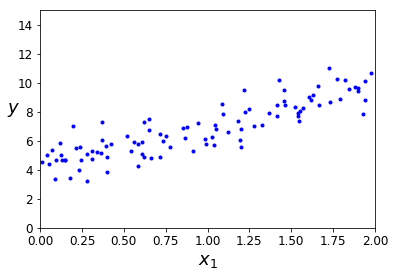

In [24]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Let's compute $\hat{\theta}$ using $(X'X)^{-1}\cdot(X'y)$. Command inv() inverts a matrix. First we add constant term to the X, which will have two features ($X_1$ and constant). $X = X[1,X_1]$. In Python matrix transposition is <font color='blue'>X_b.T<font color='black'> $=X'$, matrix multuplication $X'X$ = <font color='blue'>X_b.T.dot.X_b<font color='black'>

In [25]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best 

array([[ 4.21509616],
       [ 2.77011339]])

Actual function to generate noise was $y = 4 + 3x + u$, where $u$ is the Gaussian noise. If we were to have a lot of data we would have estimated $\theta_0 = 4$ and $\theta_1 = 3$, instead we estimate $\theta_0 = 4.21$ and $\theta_1 = 2.77$. We can see how adding more observations moves us closer to the desired parameters. We are getting closer to $[4,3]$ as $n \rightarrow \infty$ <br>

In [26]:
np.random.seed(42)
# Define function to estimate OLS as with different number of observations
def OLS(n):
    np.random.seed(42)
    X = 2 * np.random.rand(n, 1)
    y = 4 + 3 * X + np.random.randn(n, 1)
    X_b = np.c_[np.ones((n, 1)), X]  # add x0 = 1 to each instance
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return theta_best 
theta_best = OLS(100)
print("n= 100", "theta0 =" ,theta_best[0] , "theta1 =", theta_best[1] )
theta_best = OLS(1000)
print("n= 1000", "theta0 =" ,theta_best[0] , "theta1 =", theta_best[1] )
theta_best = OLS(10000)
print("n= 10000", "theta0 =" ,theta_best[0] , "theta1 =", theta_best[1] )

n= 100 theta0 = [ 4.21509616] theta1 = [ 2.77011339]
n= 1000 theta0 = [ 4.17478026] theta1 = [ 2.92260742]
n= 10000 theta0 = [ 4.03177675] theta1 = [ 2.98034911]


We can predict y for the values of x = (0,2), extreme value of x to plot the regression function.

In [27]:
np.random.seed(42)
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
# Extereme value of X
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance 因为x的定义域就为【0，2】，取到极值来作图
# Extreme value for y, knowing both bounds of X and Y will allow us to draw a line between them.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.21509616],
       [ 9.75532293]])

Plot the regression line using extreme values.

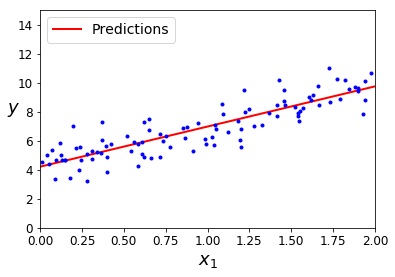

In [28]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

We can simply use prepackaged Linear Regression model from sklearn.

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.21509616]), array([[ 2.77011339]]))

In [30]:
lin_reg.predict(X_new)

array([[ 4.21509616],
       [ 9.75532293]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which you could call directly:

In [31]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[ 4.21509616],
       [ 2.77011339]])

This function computes $X^{+}y$, where $X^+$ is the pseudoinverse of $X$ (specifically the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [32]:
np.linalg.pinv(X_b).dot(y)

array([[ 4.21509616],
       [ 2.77011339]])

If we have complete linear dependence, the classication regression will fail, but SVD will not.

In [33]:
np.random.seed(42)
Q = 2 * np.random.rand(100, 1)
W = 4 + 3 * Q + np.random.randn(100, 1)
Q_b = np.c_[np.ones((100, 1)), Q, Q]  
theta_best = np.linalg.inv(Q_b.T.dot(Q_b)).dot(Q_b.T).dot(W)
print(theta_best)

[[-1008.14178262]
 [ 2039.99368946]
 [-1544.3488403 ]]


In [34]:
np.linalg.pinv(Q_b).dot(W)

array([[ 4.21509616],
       [ 1.38505669],
       [ 1.38505669]])

In [35]:
lin_reg.fit(Q_b, W)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.21509616]), array([[ 0.        ,  1.38505669,  1.38505669]]))

# Linear regression using batch gradient descent

The Normal Equation computes the inverse of $X^T · X$, which is an $n × n$ matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about O$(n^{2.4})$ to $O(n^3)$ (depending on the implementation). In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.
* However, the question is linear to the number of instances (observations) $O(m)$, so we can handle large datasets if they fit in the memory. 
* Once the coefficients are estimated, predictions are fast to make, the complexity is linear with respect to both features and instances, twice as many features will take twice the time. <br>

Next we will look how to estimate linear with very large datasets

Gradient descent minimizes a cost function.  Starting with several random numbers, you try steps in different directions testing if a step minimizes a cost function. We stop the algorithm converges -- reduction in cost function stopped. (picture).
* An important parameter in Gradient Descent is the size of the steps, determined by the learning rate hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
* If the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. (picture)
* Real-life cost function is complex and multi-dimensional. Starting point, direction of change, and the step-size can all lead to success or failure of optimization (picture). 


MSE function of linear regression is convininent for optimization. It is:
* Convex -- if you pick any two points on the curve, the line segment joining them never crosses the curve). Hence, there are not local minima, only global minimum.
* Lipschitz Continuous -- the slope does not change very rapidly, i.e. the derivative is bounded a by a real number: $ \mid  f(x_{1}) - f(x_{2}) \mid  \leq K\mid x_{1} - x_{2}\mid $, where $K \in \mathbf{R}$

These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).

**Regression with two parameters looks like a bowl, where need to find a minimum. If the features are scaled the bowl is round, and we will reach the bottom relatively quickly. If the features are not scaled different scales confuse the algorithm into thinking that features are important than others. <br>**

Training a model means searching for a combination of model parameters that minimizes a cost function. It is a search in the model's parameter space: the more parameters a model has, the more dimensions this space has, and the harder the search is. Fortunately, since the cost function is convex in the case of Linear Regression, the needle is simply at the bottom of the bowl, so there is only one minimum point.

# Batch Gradient Descent 

To implement Gradient Descent, we compute the gradient of the cost function with regards to each model parameter $θ_j$. In other words, you need to calculate how much the cost function will change if you change θj just a little bit.This is called a partial derivative. (Ex. mountain slopes facing different directions). Next we compute the partial derivative of the cost function with regards to parameter #矩阵很好解决了连加的问题
$\theta_j$, noted $\frac{\partial MSE(\theta)}{\partial \theta_j}$. 
$$
\frac{\partial MSE(\theta)}{\partial \theta_j} = \frac{2}{m}\sum\limits_{i=1}^m \big(\theta^{T} \cdot x^{(i)} - y^{(i)}\big)x^{(i)}
$$ <br>
We estimate a vector of gradients in one go. The gradient vector, noted $\nabla\theta MSE(\theta)$, contains all the partial derivatives of the cost function (one for each model parameter): 
$$
    \nabla\theta MSE(\theta)               \begin{cases}
                  \frac{\partial MSE(\theta)}{\partial \theta_0}\\
                  \frac{\partial MSE(\theta)}{\partial \theta_1}\\
                 \vdots \\
                  \frac{\partial MSE(\theta)}{\partial \theta_n}\\
                \end{cases}
$$
Notice that this formula involves calculations over the full training set X, at each Gradient Descent step! This is why the algorithm is called Batch Gradient Descent: it uses the whole batch of training data at every step. As a result it is terribly slow on very large training sets. However, Gradient Descent scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation.

Once you have the gradient vector, which points uphill, just go in the opposite direction. This means subtracting $\nabla\theta MSE(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play. multiply the gradient vector by $\eta$ to determine the size of the downhill step:
$$
\theta^{next \:step} = \theta - \eta \nabla\theta MSE(\theta)
$$


In [36]:
# set step at 0.1
eta = 0.1
# number of steps
n_iterations = 1000
# number of observations
m = 100
# randomly set the starting point
theta = np.random.randn(2,1)
# Walk 1000 steps. 
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [37]:
theta

array([[ 4.21509616],
       [ 2.77011339]])

In [38]:
# This is what we got from Matrix OLS.
theta_best = OLS(100)
print("n= 100", "theta0 =" ,theta_best[0] , "theta1 =", theta_best[1] )

n= 100 theta0 = [ 4.21509616] theta1 = [ 2.77011339]


Let's look at the first 10 steps of gradient descent algorithms with different step sizes.

In [39]:
# set a path vector
theta_path_bgd = []
# program that plots gradient descent graph
def plot_gradient_descent(theta, eta, theta_path=None):
    # Number of observations m
    m = len(X_b)
    # Plot target and features in scatter plot
    plt.plot(X, y, "b.")
    # set number of iterations
    n_iterations = 1000
    # loop over the iterations
    for iteration in range(n_iterations):
        theta_path_bgd.append(theta)
    # plot first 10 iterations
        if iteration < 10:
            # preduct y using existing theta (starting values)
            y_predict = X_new_b.dot(theta)
            # Plot first iteration with red, others in blue color
            style = "b-" if iteration > 0 else "r--" # 规避第一次循环，iteration为0的影响，标记起始点
            # Plot regression line predicting y
            plt.plot(X_new, y_predict, style)
        # Calculate gradient using formula above.
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        # Update theta using the gradient
        theta = theta - eta * gradients 
        #Save estimate thetas in the vector theta_path
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16) 

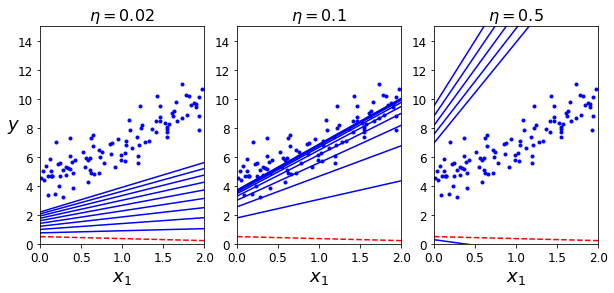

In [40]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

* On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. 
* In the middle, the learning rate looks pretty good: in just a few iterations, it has already converged to the solution
* On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step

If you have enough time it is always better to use small steps and a lot of iterations. If the data is too big for that, then you need to experiment using grid search. <br>

How to set the number of iterations? <br>
**If you set it too small, your may not find the minimum, if it is too large you may waste time without improving the fit. A good ways it set minimum gradient that would continue the iterations. If the rate of improvement is less than the minimum tolerance $\epsilon$, it is a good idea to stop the iterations.  **

When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), the Batch Gradient Descent with a fixed learning rate has a convergence rate of $ O = \frac{1}{Iterations}$. In other words, if you divide the tolerance $\epsilon$ by 10 (to have a more precise solution), then the algorithm will have to run about 10 times more iterations.

# Stochastic Gradient Descent

* Batch Gradient Descent uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large.
* Stochastic Gradient Descent (SGD) just picks a random instance in the training set at every step and computes the gradients based only on that single instance. This makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.
* SGD, due to its stochastic (i.e., random) nature, is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down . So once the algorithm stops, the final parameter values are good, but not optimal. (picture)

Note that since instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set, then go through it instance by instance, then shuffle it again, and so on. However, this generally converges more slowly.

In [41]:
# set path array
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

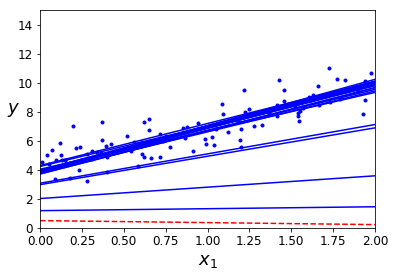

In [42]:
# number of iterations
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)
# start with randomly generated starting parameters theta
theta = np.random.randn(2,1)  # random initialization
# loop over iterations
for epoch in range(n_epochs):
    # add theta to the vector
    theta_path_sgd.append(theta)                 # not shown
    # loop over observations. Here we loop over all observations, we can just had a few draw, like range(20)
    for i in range(m):
        # show regression lines for the first 20 iterations
        if epoch == 0 and i < 20:                    # not shown in the book
            # Predict y using existing theta
            y_predict = X_new_b.dot(theta)           # not shown
            # first line is red
            style = "b-" if i > 0 else "r--"         # not shown
            #other lines are blue. Plot predictions
            plt.plot(X_new, y_predict, style)        # not shown
        # Randomly select number between 1 and m.
        random_index = np.random.randint(m)
        # extract randomly selected observation for x
        xi = X_b[random_index:random_index+1]
        # extract randomly selected observation for y
        yi = y[random_index:random_index+1]
        # Calculate gradient for randomly selected observations
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # Tolerance level, is 50 / (epoch * m + i + 5)
        eta = learning_schedule(epoch * m + i)
        # update theta
        theta = theta - eta * gradients


plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

In [43]:
thetapath = np.array(theta_path_sgd)

In [44]:
thetapath[49,:]

array([[ 4.21200431],
       [ 2.74968529]])

Remember that correct values are $[4.21509616, 2.77011339]$, we are very close

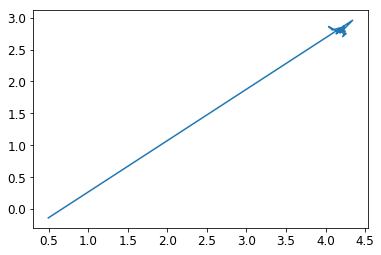

In [45]:
# First 20 steps of iteration 1
plt.plot(thetapath[0:20,0],thetapath[0:20,1])

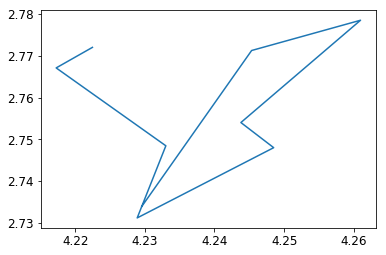

In [46]:
#40-50 steps
plt.plot(thetapath[40:49,0],thetapath[40:49,1])

We are close, but we are not really converging to the correct value. Next we estimate a SGD regression included in sklearn. Number of iterations is 50. The defaults to optimizing the squared error cost function. We run 50 epochs, starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization (penalty=None; more details on this shortly):

In [47]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None,  eta0 = 0.1,  random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.16782089]), array([ 2.72603052]))

Not great, let's increase the number of iterations

In [48]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=500, penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_  # ravel 见下 展开扁平化处理
# https://stackoverflow.com/questions/28930465/what-is-the-difference-between-flatten-and-ravel-functions-in-numpy

(array([ 4.21357582]), array([ 2.76177294]))

Much better. Alternatively we can reduce tolerance 10 times.

In [49]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=5000, penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.22518846]), array([ 2.78167189]))

The results got worse we are dancing aroung correct value.

# Mini-batch gradient descent

Instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression as we saw earlier). Next we will show the paths taken by the three Gradient Descent algorithms in parameter space during training. They all end up near the minimum, but Batch GD’s path actually stops at the minimum, while both Stochastic GD and Mini-batch GD continue to walk around. However, the Batch GD takes a lot of time to take each step, and Stochastic GD and Mini-batch GD would also reach the minimum if you used a good learning schedule.

In [50]:
theta_path_mgd = []

n_iterations = 50
# We will just use 20 observations out of 100
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    # Shuffle the data x and y. Because we will draw a series of 20 observation order now can matter a great deal. 
    #Before we were just 
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    # Loop each batch of observations from 0 to 20
    for i in range(0, m, minibatch_size):
        # set counter t
        t += 1
        # Get first of observation of the batch
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        # calculate the gradient
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        # calculate new step
        eta = learning_schedule(t)
        # update theta
        theta = theta - eta * gradients
        # record the path
        theta_path_mgd.append(theta)

In [57]:
print("final theta =",theta)

final theta = [[ 4.25214635]
 [ 2.7896408 ]]


In [52]:
# Lets create vetors for our paths
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

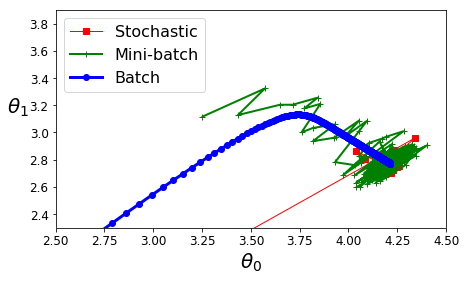

In [53]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
# We called this function 3 times, so the vector has 3000 obs instead of 1000. We just use the first 1000
plt.plot(theta_path_bgd[:1000, 0], theta_path_bgd[:1000, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

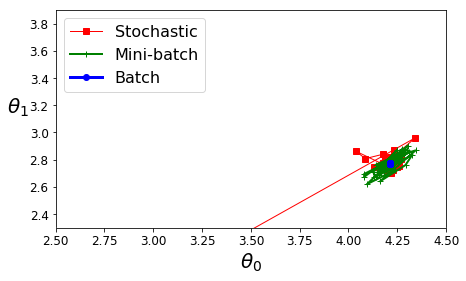

In [61]:
# Plot last 50 steps
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[-50:, 0], theta_path_sgd[-50:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[-50:, 0], theta_path_mgd[-50:, 1], "g-+", linewidth=2, label="Mini-batch")
# We called this function 3 times, so the vector has 3000 obs instead of 1000. We just use the first 1000
plt.plot(theta_path_bgd[950:1000, 0], theta_path_bgd[950:1000, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show() # 可以看到Batch会停止在最优值

# Polynomial regression

What if your data is actually more complex than a simple straight line? A simple way to use Linear model for non-linear data is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

In [62]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

X is 100 observations draws from $X = 6*R - 3$, where $R \in (0,1)$. Then we estimate $Y = 0.5X^2 + X + 2 + R$.

In [63]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Plot X and Y

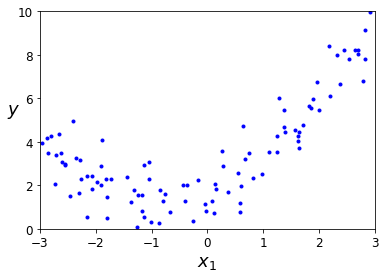

In [65]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [66]:
# Import package to craeate polinomial features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [67]:
print(X_poly[0]) # 会自动包含原值与乘方值
print((-0.75275929)**2)

[-0.75275929  0.56664654]
0.566646548681304


In [68]:
# Fit polinomial regression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.78134581]), array([[ 0.93366893,  0.56456263]]))

The model estimates $\hat{Y} = 0.56X^2 + 0.93X + 1.78 + R$, whereas a real model is $Y = 0.5X^2 + X + 2 + R$. Polinomial regresion is capable of finding relationships
between features by addint all combinations of features up to the given degree. For
example, if there were two features $a$ and $b$, PolynomialFeatures with degree=3 would not only add
the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^{2}b$,$ab^2$,and $a^{3}b^{3}$. **Polynomial features models with a degree $d$ and $n$ features, would produce $\frac{(n+d)!}{d!n!}$ combinations of features.**

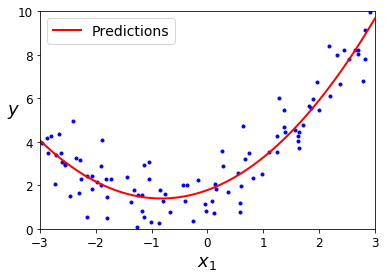

In [74]:
# Generate space of drawing a solid prediction line.
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
# square the X
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
# Draw scattered data
plt.plot(X, y, "b.")
# Draw prediction line
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")# 注意两个图的差别，线是短横杠，而点是小圆点
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

High-degree Polynomial Regression fits the training data much better than the plain Linear Regression. Next we estimate a 300-degree polynomial model to the preceding training data, and compare the result with a pure linear model and a quadratic model (2nd degree polynomial).

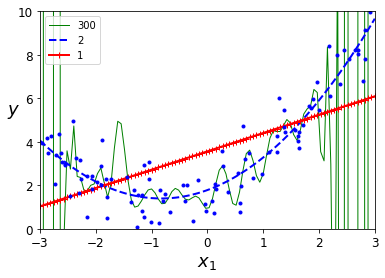

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

* This high-degree Polynomial Regression model is severely overfitting the training data, while
the linear model is underfitting it. The model that will generalize best in this case is the quadratic model.
* The data was generated using a quadratic model, but in general you won’t know what
function generated the data. In Chapter 2 you used cross-validation to get an estimate of a model’s generalization performance.

Another way is to look at the learning curves: these are plots of the model’s performance on the training
set and the validation set as a function of the training set size. To generate the plots, simply train the model
several times on different sized subsets of the training set. The following code defines a function that plots
the learning curves of a model given some training data:


In [87]:
# Import MS and train-test split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    # Split data into test and train
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    # create vectors to save errors
    train_errors, val_errors = [], []
    # loop through all observations adding one at a time
    for m in range(1, len(X_train)):
        # fit the model
        model.fit(X_train[:m], y_train[:m])
        # predict y on training
        y_train_predict = model.predict(X_train[:m])
        # predict on validation
        y_val_predict = model.predict(X_val)
        # calculate training and validation errors
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
# plot errors and sample size
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

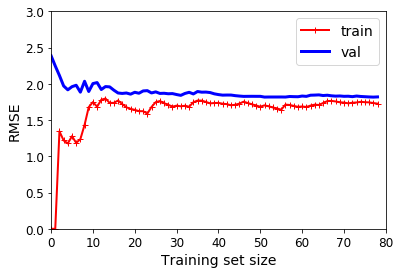

In [92]:
# Set large data
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

                                # not shownlin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()      

When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts
at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the
training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the
training data goes up until it reaches a plateau, at which point adding new instances to the training set
doesn’t make the average error much better or worse. <br>

When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve. These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high. <br>

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data.

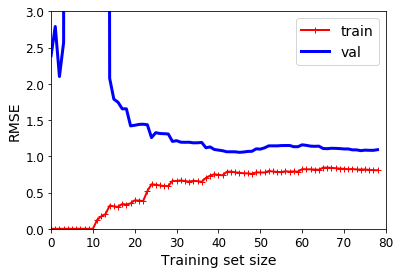

In [93]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

These learning curves look a bit like the previous ones, but there are two very important differences: <br>
1. The error on the training data is much lower than with the Linear Regression model.
2. There is a persistent gap between the curves. This means that the model performs significantly better on the
**training data than on the validation data, which is the hallmark of an overfitting model.** However, if you used a much larger training set, the two curves would continue to get closer.

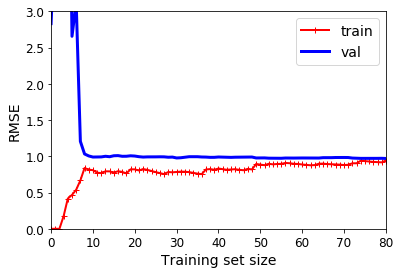

In [100]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()  

Maybe we have too few obervations?

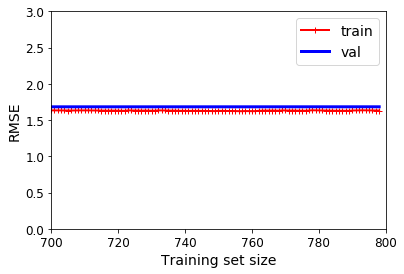

In [106]:
# Set large data
np.random.seed(42)
m = 1000
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([700, 800, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

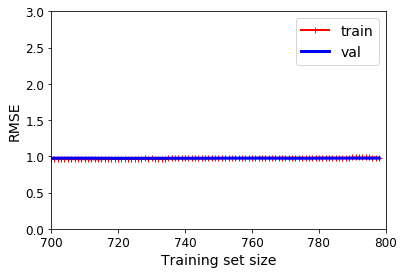

In [107]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([700, 800, 0, 3])           # not shown
plt.show()                        # not shown

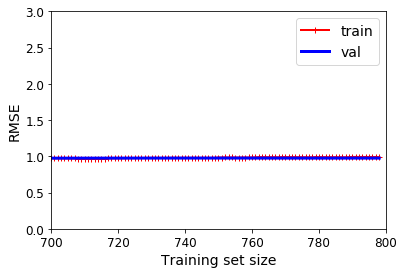

In [108]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([700, 800, 0, 3])           # not shown
plt.show()                        # not shown

**We fixed overfitting issues by using more data.**

# Regularized models

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees. <br>
For a linear model, regularization is typically achieved by constraining the weights of the model. We will
now look at **Ridge Regression**, **Lasso Regression**, and **Elastic Net**, which implement three different ways
to constrain the weights. <br>

# Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure. <br>

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$ then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. Ridge regression cost function, where we add a sum of squared parameters.
$$ J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum^m_{i=1} \theta^{2}_i$$


Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not $0$). If we define $w$ as the vector of
feature weights ($\theta_1$ to $\theta_n$), then the regularization term is simply equal to $\frac{1}{2}(\lVert w \rVert _2)^2$, where $\lVert . \rVert _2$ is teh $l_2$ norm of the weight vector. **It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale
of the input features. This is true of most regularized models. For Gradient Descent, just add $\alpha w$ to the MSE gradient
vector. <br>**

Next we will show several Ridge models trained on some linear data using different $\alpha$ value. On the left, plain Ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the Ridge models are applied to the resulting features: this is Polynomial Regression with Ridge regularization. <br>

**Increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions; this reduces the
model’s variance but increases its bias.**

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form
equation or by performing Gradient Descent. The closed-form solution (where $A$ is the $n \times n$ identity matrix except with a 0 in the top-left cell, corresponding to the bias term). 
$$ \hat{\theta} = ( X^T \cdot X  + \alpha A)^{-1} \cdot X^T \cdot y$$
Remember the regression without ridge it:
$$ \hat{\theta} = ( X^T \cdot X )^{-1} \cdot X^T \cdot y$$



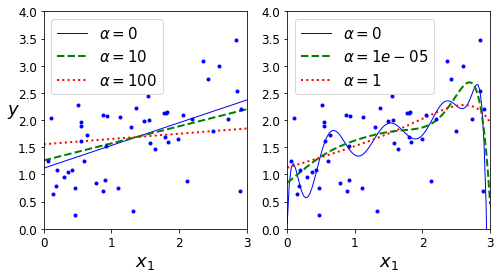

In [114]:
from sklearn.linear_model import Ridge
train_errors = []
val_errors = []
np.random.seed(42)
# Take 20 obs
m = 50
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)


X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X_train, y_train)
        y_new_regul = model.predict(X_new)
        # look at cross validation error
        y_train_predict = model.predict(X_train[:m])
        # predict on validation
        y_val_predict = model.predict(X_val)
        # calculate training and validation errors
        train_errors.append(mean_squared_error(y_train, y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
# Plot ridge regression
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

In [118]:
print("Training Errors Linear regression with Ridge",train_errors[0:3])

Training Errors Linear regression [0.38502216335855921, 0.39318856550819542, 0.46256729165071492]


In [119]:
print("Validation Errors Linear regression with Ridge",val_errors[0:3])

Validation Errors Linear regression [0.29316797864575589, 0.32582567377726052, 0.44095925341635367]


In [120]:
print("Training Errors Polynomial regression with Ridge",train_errors[3:])

Training Errors Polynomial regression [0.32527325068022717, 0.35973102995007256, 0.37882273435004687]


In [121]:
print("Validation Errors Polinomial regression with Ridge",val_errors[3:])

Validation Errors Polinomial regression [0.2874513212562495, 0.29210668090140729, 0.27936817099901379]


**Ridge regression improves fit of complex polynomial model and worsens the fit of simple linear model.** 

本来是解决过度拟合的问题，线性回归本来就是有拟合不充分的问题

# Lasso Regression 

Least Absolute Shrinkage and Selection Operator Regression (simply called Lasso Regression) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the $l_1$ norm of the weight vector instead of half the square of the $l_2$ norm.

$$ J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum^m_{i=1} |\theta_i|$$

**An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the
least important features (i.e., set them to zero).** For example, the dashed line in the right plot on a figure below (with $\alpha$ = $10^{-7}$) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

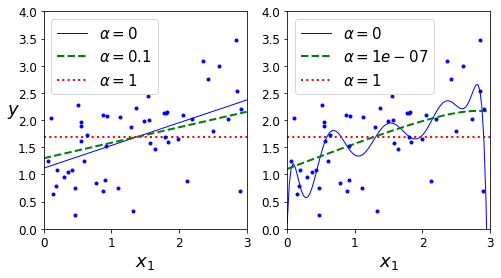

In [125]:
from sklearn.linear_model import Lasso
train_errors = []
val_errors = []
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

In [126]:
print("Training Errors Linear regression Lasso",train_errors[0:3])

Training Errors Linear regression Lasso [0.38502216335855921, 0.39831740048510761, 0.5162468019225317]


In [127]:
print("Validation Errors Linear regression with Lasso",val_errors[0:3])

Validation Errors Linear regression with Lasso [0.29316797864575589, 0.33742606138130138, 0.51274635613837793]


In [128]:
print("Training Errors Polynomial regression with Lasso",train_errors[3:])

Training Errors Polynomial regression with Lasso [0.32527325068022717, 0.38187782102357232, 0.5162468019225317]


In [129]:
print("Validation Errors Polinomial regression with Lasso",val_errors[3:])

Validation Errors Polinomial regression with Lasso [0.2874513212562495, 0.31152267868041178, 0.51274635613837793]


In our example Lasso regression worsens the fit.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [130]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

For example, the dashed line in the right plot on (with $\alpha$ = 10-7) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs asparse model (i.e., with few nonzero feature weights). <br>
You can get a sense of why this is the case by looking at on the top-left plot, the background contours (ellipses) represent an unregularized MSE cost function ($\alpha$ = 0), and the white circles show the Batch Gradient Descent path with that cost function. 
<br>
The foreground contours (diamonds) represent the $l_1$ penalty, and the triangles show the BGD path for this penalty only ($\alpha - \inf$). Notice how the path first reaches $\theta_1 = 0$, then rolls down a gutter until it reaches $\theta_2 = 0$. <br>

On the top-right plot, the contours represent the same cost function plus an $l_1$ penalty with $\alpha = 0.5$ The global minimum is on the $\theta_2 = 0$ axis.

The two bottom plots show the same thing but uses an $l_2$ penalty instead. The regularized minimum is closer to $\theta = 0$ than the unregularized minimum, but the weights do not get fully eliminated.    

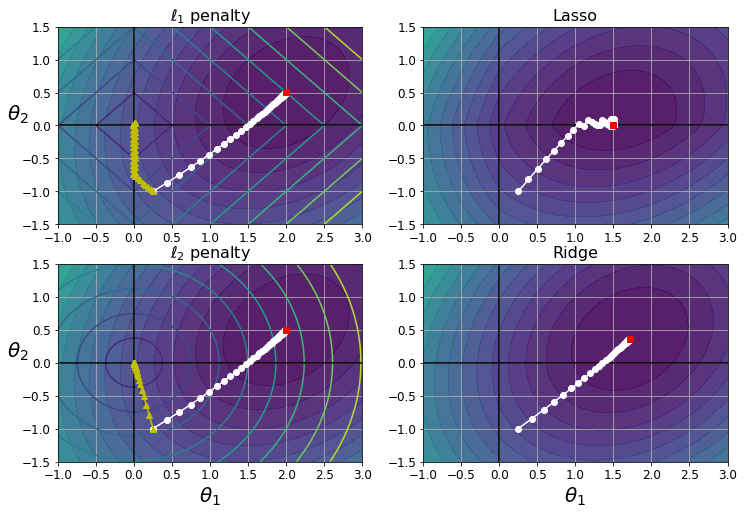

In [131]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
plt.show()

# Elastic net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term
is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio $r$. When
$r = 0$, Elastic Net is equivalent to Ridge Regression, and when $r = 1$, it is equivalent to Lasso Regression.

$$ J(\theta) = MSE(\theta) + r \alpha \frac{1}{2} \sum^m_{i=1} |\theta_i| + \frac{1-r}{2} \sum^m_{i=1} \theta_i^2 $$

So when should you use Linear Regression, Ridge, Lasso, or Elastic Net? It is almost always preferable
to have at least a little bit of regularization, so generally you should avoid plain Linear Regression.
* Ridge is a good default,
* if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero.
* In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.


# Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop
training as soon as the validation error reaches a minimum. This is called early stopping. Figure next 
shows a complex model (in this case a high-degree Polynomial Regression model) being trained using Batch Gradient Descent. As the epochs go by, the algorithm learns and its prediction error (RMSE) on the training set naturally goes down, and so does its prediction error on the validation set. However, after a while the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. 

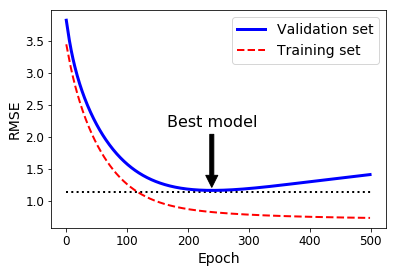

In [133]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# Logistic regression

Some regression algorithms can be used for classification as well (and vice versa). Logistic Regression (also called Logit Regression) is commonly used to estimate the
probability that an instance belongs to a particular class (e.g., what is the probability that this email is
spam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs
to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to
the negative class, labeled “0”). This makes it a binary classifier

$$ \hat{p} = h_\theta (x) = \sigma(\theta^T \cdot x)$$
Logit function is:
$$ \sigma(t) = \frac{1}{1 + exp(-t)}$$

Saving figure logistic_function_plot


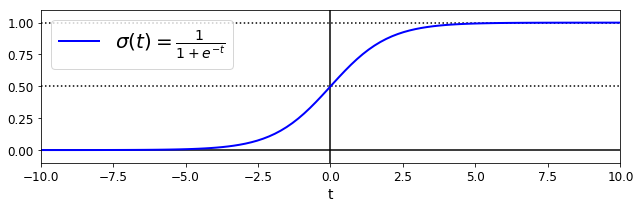

In [51]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

if $\hat{p} < 0.5$ then $\hat{y} = 0$ <br>
if $\hat{p} > 0.5$ then $\hat{y} = 1$

In [1]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [53]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [137]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

In [138]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

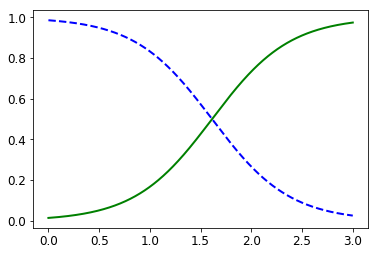

In [56]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")

The figure in the book actually is actually a bit fancier:

Saving figure logistic_regression_plot


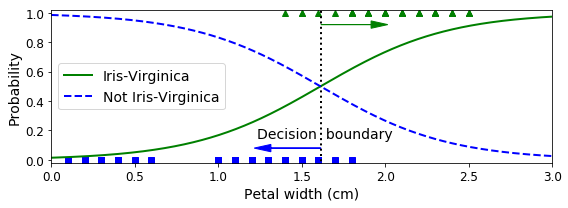

In [57]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0] # >=0.5合集中的第一个抵达值

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [58]:
decision_boundary

array([1.61561562])

In [59]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Saving figure logistic_regression_contour_plot


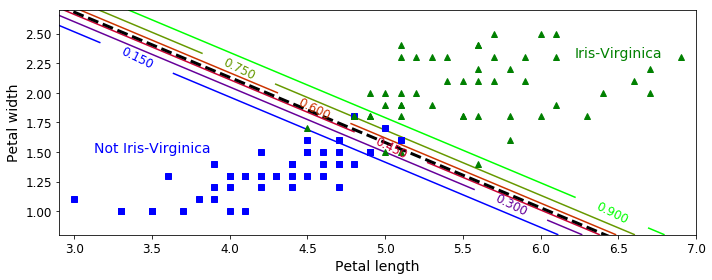

In [60]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [61]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Saving figure softmax_regression_contour_plot


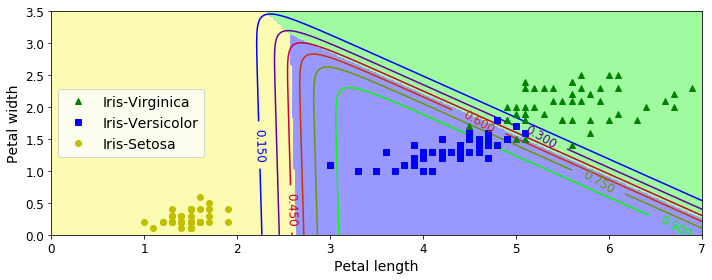

In [62]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [63]:
softmax_reg.predict([[5, 2]])

array([2])

In [64]:
softmax_reg.predict_proba([[5, 2]])

array([[6.33134077e-07, 5.75276067e-02, 9.42471760e-01]])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [2]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [4]:
import numpy as np
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [5]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [7]:
rnd_indices

array([ 33,  99, 147,  53,  88,  22,  65,  52,  50,  49,  91, 103,  12,
        68,  82, 108,  76,  61,  45, 107,  85,  58,  80, 137,  16,  43,
        34, 117,   6,  74, 118,  17, 128,  66,  59, 122,  78,  44,  25,
        51, 125, 124, 136, 134,   5, 110,  40, 100, 114, 133, 126,  36,
         2,  92,  96, 105,   1,  27,  63,   9, 121,  41,  60,  89, 112,
       120, 132,  10,  18,  29, 142,  84, 143,  77,  31,  73,  14,  56,
       106, 115,  69,  23, 109, 123,  37, 113,   3,  42,  28,  24,  13,
       146,  39,  32,  79, 130, 140,  21,  38,  47,  55,  72, 138, 149,
        90,  98, 141,  67, 104,  93,   4,  54, 135, 101,  86,  35,  19,
        87,  64, 119,  70, 139, 102,  81,  71,  62,  11,  30,   7, 116,
        46,  97, 129,  26,  95,  75, 127, 145, 131,   8, 144,  57,   0,
       148,  48,  20,  83,  15, 111,  94])

In [8]:
X_with_bias

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.7, 0.4],
       [1. , 1.4, 0.3],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.5, 0.1],
       [1. , 1.5, 0.2],
       [1. , 1.6, 0.2],
       [1. , 1.4, 0.1],
       [1. , 1.1, 0.1],
       [1. , 1.2, 0.2],
       [1. , 1.5, 0.4],
       [1. , 1.3, 0.4],
       [1. , 1.4, 0.3],
       [1. , 1.7, 0.3],
       [1. , 1.5, 0.3],
       [1. , 1.7, 0.2],
       [1. , 1.5, 0.4],
       [1. , 1. , 0.2],
       [1. , 1.7, 0.5],
       [1. , 1.9, 0.2],
       [1. , 1.6, 0.2],
       [1. , 1.6, 0.4],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.6, 0.2],
       [1. , 1.6, 0.2],
       [1. , 1.5, 0.4],
       [1. , 1.5, 0.1],
       [1. , 1.4, 0.2],
       [1. , 1.5, 0.1],
       [1. , 1.2, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.1],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.3, 0.3],
       [1. , 1.3

In [6]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)# shuffle data 
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.permutation.html

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [9]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))# 10 行 3 列
    Y_one_hot[np.arange(m), y] = 1 
    # arange Select one element from each row of a using the indices in b
    # http://cs231n.github.io/python-numpy-tutorial/#numpy-arrays
    return Y_one_hot

Let's test this function on the first 10 instances:

In [70]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [71]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [72]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [73]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [74]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [75]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446183864821945
500 0.8351003035768683
1000 0.6876961554414912
1500 0.6010299835452122
2000 0.5442782811959167
2500 0.5037262742244605
3000 0.4728357293908468
3500 0.4481872508179334
4000 0.4278347262806174
4500 0.4105891022823527
5000 0.39568032574889406


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [76]:
Theta

array([[ 3.3172417 , -0.6476445 , -2.99855999],
       [-1.16505434,  0.11283387,  0.10251113],
       [-0.72087779, -0.083875  ,  1.48587045]])

Let's make predictions for the validation set and check the accuracy score:

In [77]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [78]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629574947908294
500 0.5341631554372782
1000 0.5037712748637474
1500 0.4948056455575166
2000 0.49140819484111964
2500 0.4900085074445459
3000 0.48940742896132616
3500 0.4891431024691195
4000 0.48902516549065855
4500 0.48897205809605315
5000 0.4889480004791563


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [79]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [80]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.70940845273367
500 0.5740996073458012
1000 0.5436382813658034
1500 0.535638768431427
2000 0.5332563789170385
2500 0.5326544271776569
2765 0.5326058224570446
2766 0.5326058230506047 early stopping!


In [81]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

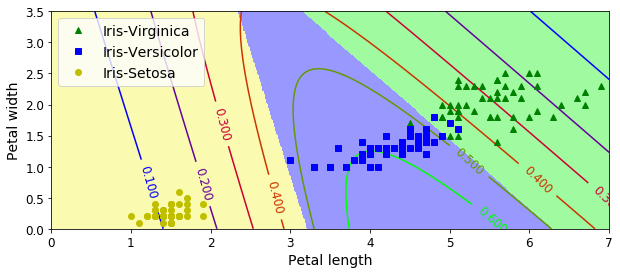

In [82]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [83]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.